In [ ]:
# %% [markdown]
# # Akademische Sentimentanalyse-Pipeline auf Kaggle-Daten
# 
# Dieses Notebook implementiert eine vollständige Pipeline zur Sentimentanalyse auf einem Kaggle-Datensatz (z.B. mit Twitter-Daten). 
# Es umfasst folgende Schritte:
# 1. Installation und Import benötigter Pakete.
# 2. Datenladen und Vorverarbeitung (inklusive Spacy-basierter Bereinigung in Batches).
# 3. Anwendung eines vortrainierten Sentiment-Classifiers (HuggingFace Transformers: *cardiffnlp/twitter-roberta-base-sentiment*) auf den bereinigten Text.
# 4. Speicherung der gewonnenen Sentiment-Features (Label und Score) im DataFrame.
# 5. Visualisierung der Sentiment-Verteilungen und Analyse des Zusammenhangs mit den Bot-Labels.
#
# Dieses Setup bietet eine solide Basis, um anschließend in verschiedenen Modellen (Raw, Fine-Tuned, Fine-Tuned+SpaCy) Sentimentinformationen als zusätzliche Features zu integrieren.

# %% [code]
# Installation der notwendigen Pakete (falls noch nicht vorhanden)
# Führe diese Zelle einmal aus.
%pip install --upgrade pip
%pip install transformers torch tqdm spacy matplotlib pandas
%pip install --upgrade ipywidgets tqdm
# Lade das kleine englische Spacy-Modell (falls noch nicht vorhanden)
!%python -m spacy download en_core_web_sm

# %% [code]
import os
import random
import pandas as pd
import numpy as np
import spacy
import string
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf  # Für spätere Integration, falls nötig

from transformers import pipeline

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ---------------------------------------- 2.3/2.3 MB 14.7 MB/s eta 0:00:00


C:\Users\uhumb\AppData\Roaming\Python\Python39\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Defaulting to user installation because normal site-packages is not writeable
     --------------------------------------- 12.8/12.8 MB 15.7 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


C:\Users\uhumb\AppData\Roaming\Python\Python39\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
# %% [markdown]
# ## 1. Daten laden und Vorverarbeitung
# 
# Wir gehen davon aus, dass der Kaggle-Datensatz in der Datei `data/twitter_dataset.csv` liegt. 
# Die relevanten Spalten sind u.a. "Tweet", "Hashtags" und "Bot Label". 
# Zur Beschleunigung der Textbereinigung nutzen wir `nlp.pipe`.

# %% [code]
# Datenpfad anpassen, falls nötig
data_path = os.path.join("twitter_dataset.csv")
df = pd.read_csv(data_path)

# Stelle sicher, dass die Spalte "Tweet" als String vorliegt
df["Tweet"] = df["Tweet"].astype(str)

# %% [markdown]
# ### Spacy-basierte Bereinigung in Batches
# 
# Wir verwenden spacy's nlp.pipe, um alle Tweets in Batches zu verarbeiten und so die Laufzeit zu reduzieren.

# %% [code]
# Lade das Spacy-Modell (englisch)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # Wir brauchen nur Tokenisierung, Lemmatisierung, Stopwords

tweets = df["Tweet"].tolist()
cleaned_tweets = []

# Verarbeite die Texte in Batches mit tqdm zur Fortschrittsanzeige
for doc in tqdm(nlp.pipe(tweets, batch_size=50), total=len(tweets), desc="Cleaning tweets"):
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    cleaned_tweets.append(" ".join(tokens))

df["cleaned_Tweet"] = cleaned_tweets

Cleaning tweets: 100%|██████████| 50000/50000 [01:30<00:00, 555.43it/s]


In [4]:
# %% [markdown]
# Zusätzlich berechnen wir ein paar Basis-Features:
# - Tweet-Länge
# - Anzahl der Hashtags (einfaches Splitting der Spalte "Hashtags")

# %% [code]
df["tweet_length"] = df["Tweet"].apply(lambda x: len(x))
df["num_hashtags"] = df["Hashtags"].apply(lambda x: len(str(x).split()) if pd.notnull(x) and str(x).strip() != "" else 0)

# Stelle sicher, dass numerische Spalten korrekt sind
numeric_base = ["Retweet Count", "Mention Count", "Follower Count", "Verified"]
for col in numeric_base:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# Stelle sicher, dass das Ziel als Integer vorliegt
df["Bot Label"] = df["Bot Label"].astype(int)

In [5]:
# %% [markdown]
# ## 2. Sentimentanalyse
# 
# Wir verwenden einen vortrainierten Sentiment-Classifier aus HuggingFace. 
# Für Twitter-ähnliche Texte eignet sich beispielsweise das Modell „cardiffnlp/twitter-roberta-base-sentiment“.
# Beachte: Dieses Modell liefert typischerweise drei Labels (z.B. NEGATIVE, NEUTRAL, POSITIVE) sowie Score-Werte.

# %% [code]
# Erstelle den Sentiment-Analysis-Pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Wende die Sentimentanalyse auf die bereinigten Tweets an.
# Um Zeit zu sparen, verarbeite die Texte in Batches.
sentiment_labels = []
sentiment_scores = []

print("Analysing sentiment for tweets...")
for text in tqdm(df["cleaned_Tweet"], total=len(df)):
    try:
        result = sentiment_analyzer(text)[0]
        sentiment_labels.append(result["label"])
        sentiment_scores.append(result["score"])
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        sentiment_labels.append(None)  # Oder einen Standardwert
        sentiment_scores.append(None)

df["sentiment_label"] = sentiment_labels
df["sentiment_score"] = sentiment_scores


Device set to use cpu


Analysing sentiment for tweets...


  0%|          | 0/50000 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

  0%|          | 211/50000 [00:25<1:21:12, 10.22it/s]C:\Users\uhumb\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\uhumb\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
100%|██████████| 50000/50000 [5

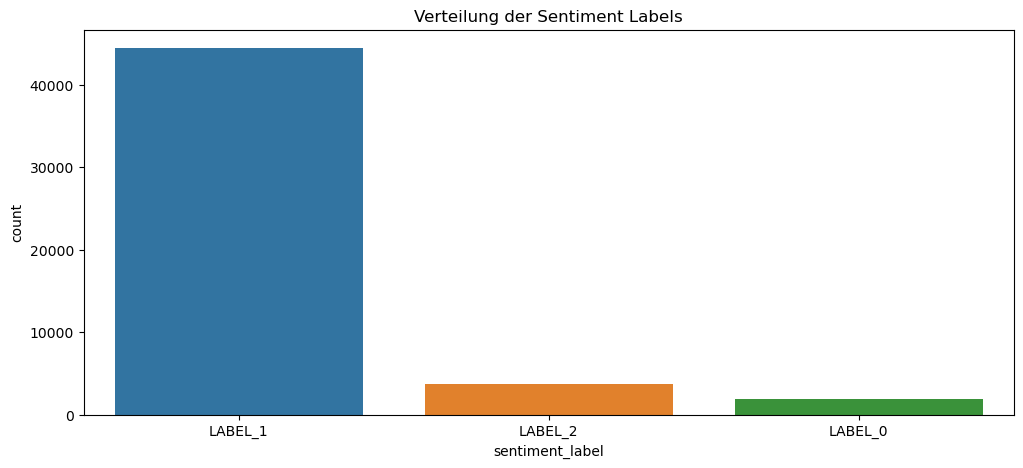

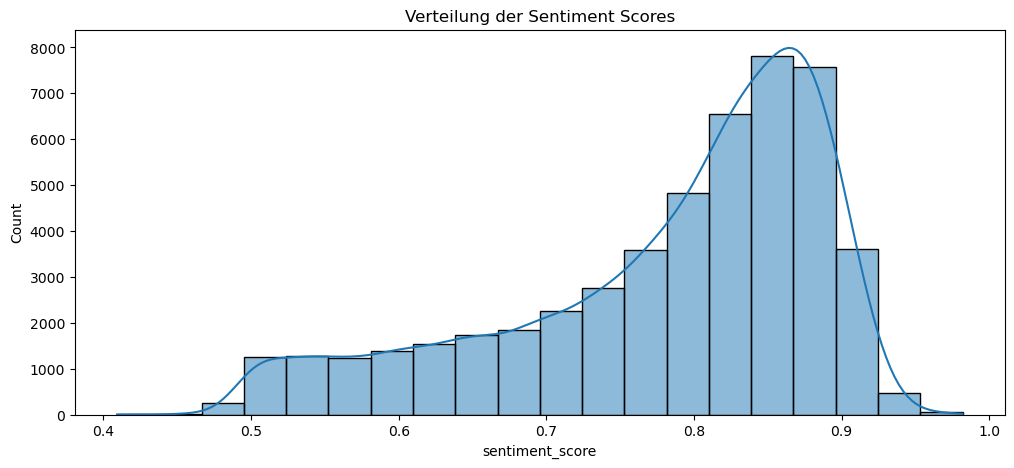

Kreuztabelle Sentiment Label vs. Bot Label:
Bot Label            0      1
sentiment_label              
LABEL_0            910    962
LABEL_1          22186  22282
LABEL_2           1886   1774


In [6]:
# %% [markdown]
# **Hinweis:**  
# Du kannst zusätzlich auch eine Sentimentanalyse auf den Community Notes durchführen, falls du diese separat nutzen möchtest.  
# Hier fokussieren wir uns auf die Tweets.

# %% [markdown]
# ## 3. Visualisierung der Sentiment Features
# 
# Wir plotten die Verteilung der Sentiment-Labels und -Scores und untersuchen, ob es einen Zusammenhang mit den Bot Labels gibt.

# %% [code]
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.countplot(x="sentiment_label", data=df)
plt.title("Verteilung der Sentiment Labels")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df["sentiment_score"], bins=20, kde=True)
plt.title("Verteilung der Sentiment Scores")
plt.show()

# Kreuztabelle Sentiment vs. Bot Label
ct = pd.crosstab(df["sentiment_label"], df["Bot Label"])
print("Kreuztabelle Sentiment Label vs. Bot Label:")
print(ct)


In [7]:
# %% [markdown]
# ## 4. Train-Test-Aufteilung und Export der erweiterten Daten
# 
# Wir teilen den Datensatz in Trainings- und Testdaten (80/20-Aufteilung) und speichern die erweiterten Features.
# Diese erweiterten Features (einschließlich der Sentiment-Spalten) können dann als zusätzliche Eingabefeatures in weitere Modelle integriert werden.

# %% [code]
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

print("Trainingsbeispiele:", len(train_df), "Testbeispiele:", len(test_df))

# Optional: Speichere den erweiterten Datensatz als CSV für spätere Modellierung
train_df.to_csv("train_extended.csv", index=False)
test_df.to_csv("test_extended.csv", index=False)

print("Erweiterte Datensätze gespeichert: train_extended.csv und test_extended.csv")

Trainingsbeispiele: 40000 Testbeispiele: 10000
Erweiterte Datensätze gespeichert: train_extended.csv und test_extended.csv
